In [ ]:
pip install mplsoccer

In [ ]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mplsoccer import Pitch
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import export_graphviz,plot_tree
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

In [3]:
fixtures = pd.read_csv('fixtures.csv')
teams = pd.read_csv('teams.csv')
odds = pd.read_csv('odds.csv')
players = pd.read_csv('players.csv')
results = pd.read_csv('results.csv')
starting_eleven = pd.read_csv('startingXI.csv')


In [146]:
results.head()

,SeasonID,Gameweek,MatchID,HomeTeamID,HomeScore,HomeShots,AwayTeamID,AwayScore,AwayShots
0,1,1,1,7,1,17,1,1,12
1,1,1,2,6,1,8,8,3,17
2,1,1,3,5,5,21,9,1,7
3,1,1,4,4,2,25,10,0,8
4,1,1,5,3,3,13,11,3,19


## Exploring the first season

In [6]:
results.describe()

,SeasonID,Gameweek,MatchID,HomeTeamID,HomeScore,HomeShots,AwayTeamID,AwayScore,AwayShots
count,1512.000000,1512.000000,1512.000000,1512.00000,1512.000000,1512.000000,1512.00000,1512.000000,1512.000000
mean,1.500000,27.500000,756.500000,14.50000,1.704365,14.978836,14.50000,1.329365,11.746032
std,0.500165,15.590941,436.621117,8.08042,1.508162,6.618133,8.08042,1.330788,5.543790
min,1.000000,1.000000,1.000000,1.00000,0.000000,1.000000,1.00000,0.000000,1.000000
25%,1.000000,14.000000,378.750000,7.75000,1.000000,10.000000,7.75000,0.000000,8.000000
50%,1.500000,27.500000,756.500000,14.50000,1.000000,14.000000,14.50000,1.000000,11.000000
75%,2.000000,41.000000,1134.250000,21.25000,3.000000,19.000000,21.25000,2.000000,15.000000
max,2.000000,54.000000,1512.000000,28.00000,9.000000,47.000000,28.00000,10.000000,38.000000


In [147]:
first_season = results[results['SeasonID'] == 1].copy()
first_season.head()

,SeasonID,Gameweek,MatchID,HomeTeamID,HomeScore,HomeShots,AwayTeamID,AwayScore,AwayShots
0,1,1,1,7,1,17,1,1,12
1,1,1,2,6,1,8,8,3,17
2,1,1,3,5,5,21,9,1,7
3,1,1,4,4,2,25,10,0,8
4,1,1,5,3,3,13,11,3,19


1. **Which team won the league in the first season?**

In [148]:
# Aggregate results for each team
home_results = first_season.groupby('HomeTeamID').agg(
    Wins=('HomeScore', lambda x: (x > results.loc[x.index, 'AwayScore']).sum()),
    Draws=('HomeScore', lambda x: (x == results.loc[x.index, 'AwayScore']).sum()),
    Losses=('HomeScore', lambda x: (x < results.loc[x.index, 'AwayScore']).sum()),
    GoalsFor=('HomeScore', 'sum'),
    GoalsAgainst=('AwayScore', 'sum')
).reset_index().rename(columns={'HomeTeamID': 'TeamID'})

away_results = first_season.groupby('AwayTeamID').agg(
    Wins=('AwayScore', lambda x: (x > results.loc[x.index, 'HomeScore']).sum()),
    Draws=('AwayScore', lambda x: (x == results.loc[x.index, 'HomeScore']).sum()),
    Losses=('AwayScore', lambda x: (x < results.loc[x.index, 'HomeScore']).sum()),
    GoalsFor=('AwayScore', 'sum'),
    GoalsAgainst=('HomeScore', 'sum')
).reset_index().rename(columns={'AwayTeamID': 'TeamID'})

final_results = home_results.set_index('TeamID').add(away_results.set_index('TeamID'), fill_value=0).reset_index()
final_results['Points'] = final_results['Wins'] * 3 + final_results['Draws']
final_results['GoalDifference'] = final_results['GoalsFor'] - final_results['GoalsAgainst']
final_results = final_results.merge(teams, on='TeamID')
final_results = final_results.sort_values(by=['Points', 'GoalDifference','GoalsFor','GoalsAgainst'], ascending=False).reset_index(drop=True)

# final_results['Matches'] = 54
final_results

,TeamID,Wins,Draws,Losses,GoalsFor,GoalsAgainst,Points,GoalDifference,TeamName
0,15,44,6,4,159,41,138,118,Miami
1,8,39,8,7,130,51,125,79,Cincinnati
2,4,35,12,7,136,41,117,95,Baltimore
3,19,34,11,9,108,52,113,56,New York S
4,5,31,13,10,130,58,106,72,Boston
5,27,31,12,11,118,64,105,54,Seattle
6,6,32,9,13,110,56,105,54,Chicago B
7,21,27,15,12,98,66,96,32,Oakland
8,7,28,11,15,97,75,95,22,Chicago H
9,24,27,13,14,108,62,94,46,St. Louis


i) This is the league table after 108 games and Miami won the league with 271 points

2. **At what point in the season did that team secure their league title?**

In [ ]:
first_season.loc[:, 'HomePoints'] = first_season.apply(lambda x: 3 if x['HomeScore'] > x['AwayScore'] else (1 if x['HomeScore'] == x['AwayScore'] else 0), axis=1)
first_season.loc[:, 'AwayPoints'] = first_season.apply(lambda x: 3 if x['AwayScore'] > x['HomeScore'] else (1 if x['AwayScore'] == x['HomeScore'] else 0), axis=1)
cumulative_points = first_season.groupby(['Gameweek', 'HomeTeamID'])['HomePoints'].sum().unstack(fill_value=0).cumsum(axis=0).add(
    first_season.groupby(['Gameweek', 'AwayTeamID'])['AwayPoints'].sum().unstack(fill_value=0).cumsum(axis=0), fill_value=0)
 
# Identify Miami's TeamID
miami_team_id = teams.loc[teams['TeamName'] == 'Miami', 'TeamID'].iloc[0]

# Check when Miami's points became unassailable
for gameweek in cumulative_points.index:
    miami_points = cumulative_points.loc[gameweek, miami_team_id]
    max_other_points = cumulative_points.loc[gameweek].drop(miami_team_id).max()
    max_team = cumulative_points.loc[gameweek].drop(miami_team_id).idxmax()
    if miami_points > max_other_points + 3 * (first_season['Gameweek'].max() - gameweek):
        print("ii)")
        print(f"Miami won the league in Gameweek {gameweek} with {miami_points} points.")
        print(f"The second team was {teams.loc[teams['TeamID'] == max_team, 'TeamName'].values[0]} with {max_other_points} points.")
        print(f"The maximum {teams.loc[teams['TeamID'] == max_team, 'TeamName'].values[0]} could achieve after Gameweek {gameweek} is {max_other_points + 3 * (first_season['Gameweek'].max() - gameweek)} points.")
        break

ii)
Miami won the league in Gameweek 50 with 128 points.
The second team was Cincinnati with 115 points.
The maximum Cincinnati could achieve after Gameweek 50 is 127 points.


3. **What result was the biggest upset?**

i) In terms of Odds

In [ ]:

first_season.loc[:, 'ActualResult'] = first_season.apply(
    lambda x: 1 if x['HomeScore'] > x['AwayScore'] else (-1 if x['HomeScore'] < x['AwayScore'] else 0), axis=1
)
results_with_odds = first_season.merge(odds, on='MatchID')
results_with_odds['Home_prob'] = 1 / results_with_odds['Home'] 
results_with_odds['Draw_prob'] = 1 / results_with_odds['Draw'] 
results_with_odds['Away_prob'] = 1 / results_with_odds['Away'] 
results_with_odds['total_prob'] = results_with_odds['Home_prob'] + results_with_odds['Draw_prob'] + results_with_odds['Away_prob']
results_with_odds['ExpectedHomeWin'] = (results_with_odds['Home_prob'] / results_with_odds['total_prob']) * 100
results_with_odds['ExpectedDraw'] = (results_with_odds['Draw_prob'] / results_with_odds['total_prob']) *100
results_with_odds['ExpectedAwayWin'] = (results_with_odds['Away_prob'] / results_with_odds['total_prob']) * 100
results_with_odds['ActualProbability'] = results_with_odds.apply(
    lambda x: x['ExpectedHomeWin'] if x['ActualResult'] == 1 else (
        x['ExpectedDraw'] if x['ActualResult'] == 0 else x['ExpectedAwayWin']
    ), axis=1
)

def get_top_upsets_odds(results_with_odds, teams, n):
    """
    Returns the top n upsets (lowest actual probability) as a DataFrame.
    """
    upsets = results_with_odds.nsmallest(n, 'ActualProbability').copy()
    upsets['HomeTeam'] = upsets['HomeTeamID'].map(teams.set_index('TeamID')['TeamName'])
    upsets['AwayTeam'] = upsets['AwayTeamID'].map(teams.set_index('TeamID')['TeamName'])
    upsets['Result'] = upsets['ActualResult'].map({1: 'Home Win', 0: 'Draw', -1: 'Away Win'})
    return upsets[['MatchID', 'HomeTeam', 'AwayTeam', 'Result', 'ActualProbability']]
get_top_upsets_odds(results_with_odds, teams, 10)

,MatchID,HomeTeam,AwayTeam,Result,ActualProbability
167,168,Miami,Milwaukee,Draw,4.170085
384,385,Miami,Atlanta,Draw,4.726424
714,715,Arlington,Houston,Away Win,5.582921
17,18,San Francisco,Boston,Home Win,7.480672
521,522,New York S,San Diego,Draw,7.653387
450,451,Seattle,Pittsburgh,Away Win,7.776240
307,308,Baltimore,Atlanta,Away Win,7.991504
271,272,Anaheim,New York S,Home Win,8.935785
47,48,Montreal,Cincinnati,Home Win,9.034083
558,559,Baltimore,Toronto,Away Win,9.280023


These are some of the upsets in terms of odds based on game results having the lowest probability of occurence.

ii) In terms of results

In [ ]:
standings_history = []

for gw in sorted(first_season['Gameweek'].unique()):
    up_to_gw = first_season[first_season['Gameweek'] <= gw]
    home = up_to_gw.groupby('HomeTeamID')['HomePoints'].sum()
    away = up_to_gw.groupby('AwayTeamID')['AwayPoints'].sum()
    points = home.add(away, fill_value=0)
    gf = up_to_gw.groupby('HomeTeamID')['HomeScore'].sum().add(
        up_to_gw.groupby('AwayTeamID')['AwayScore'].sum(), fill_value=0)
    ga = up_to_gw.groupby('HomeTeamID')['AwayScore'].sum().add(
        up_to_gw.groupby('AwayTeamID')['HomeScore'].sum(), fill_value=0)
    gd = gf - ga
    standings = pd.DataFrame({
        'TeamID': points.index,
        'Points': points.values,
        'GoalDifference': gd.values,
        'GoalsFor': gf.values,
        'Gameweek': gw
    })
    standings = standings.sort_values(
        by=['Points', 'GoalDifference', 'GoalsFor'], ascending=[False, False, False]
    ).reset_index(drop=True)
    standings['Position'] = standings.index + 1
    standings_history.append(standings)

standings_history = pd.concat(standings_history, ignore_index=True)

def get_position(row, team_col):
    pos = standings_history[
        (standings_history['Gameweek'] == row['Gameweek'] - 1) & 
        (standings_history['TeamID'] == row[team_col])
    ]
    if pos.empty:
        pos = standings_history[
            (standings_history['Gameweek'] == row['Gameweek']) & 
            (standings_history['TeamID'] == row[team_col])
        ]
    return pos['Position'].values[0]

first_season['HomePosition'] = first_season.apply(lambda row: get_position(row, 'HomeTeamID'), axis=1)
first_season['AwayPosition'] = first_season.apply(lambda row: get_position(row, 'AwayTeamID'), axis=1)
first_season['PositionDifference'] = abs(first_season['HomePosition'] - first_season['AwayPosition'])


In [15]:
def get_top_upsets(first_season, teams, n):
    """
    Returns the top n upsets (highest upset score) as a DataFrame.
    """
    # Add actual result as a string for clarity
    first_season['Result'] = first_season['ActualResult'].map({1: 'Home Win', 0: 'Draw', -1: 'Away Win'})

    def is_upset(row):
        if row['Result'] == 'Home Win':
            return row['HomePosition'] > row['AwayPosition']
        elif row['Result'] == 'Away Win':
            return row['AwayPosition'] > row['HomePosition']
        else:
            return False  

    def upset_score(row):
        base = abs(row['HomeScore'] - row['AwayScore'])
        pos_diff = abs(row['HomePosition'] - row['AwayPosition'])
        if row['Result'] == 'Away Win':
            return (pos_diff * 1.5 + base ) / 2  
        else:
            return (pos_diff + base ) / 2

    first_season['IsUpset'] = first_season.apply(is_upset, axis=1)
    first_season['UpsetScore'] = first_season.apply(upset_score, axis=1)

    upsets = first_season[first_season['IsUpset']].sort_values('UpsetScore', ascending=False).head(n)

    upsets = upsets.merge(teams[['TeamID', 'TeamName']], left_on='HomeTeamID', right_on='TeamID', how='left') \
                   .rename(columns={'TeamName': 'HomeTeam'}).drop('TeamID', axis=1)
    upsets = upsets.merge(teams[['TeamID', 'TeamName']], left_on='AwayTeamID', right_on='TeamID', how='left') \
                   .rename(columns={'TeamName': 'AwayTeam'}).drop('TeamID', axis=1)

    return upsets[['MatchID', 'HomeTeam', 'AwayTeam', 'HomeScore', 'AwayScore', 'Result', 'HomePosition', 'AwayPosition', 'UpsetScore']]

# Example usage:
get_top_upsets(first_season, teams, 5)

,MatchID,HomeTeam,AwayTeam,HomeScore,AwayScore,Result,HomePosition,AwayPosition,UpsetScore
0,49,New York S,Chicago H,1,3,Away Win,4,26,17.5
1,308,Baltimore,Atlanta,2,3,Away Win,3,23,15.5
2,82,Milwaukee,Oakland,1,5,Away Win,9,25,14.0
3,67,Detroit,Montreal,2,0,Home Win,27,3,13.0
4,18,San Francisco,Boston,2,1,Home Win,26,1,13.0


### Weighted Average Formula and UpsetScore Evaluation

The **weighted average formula** is used to calculate a single representative value by assigning different weights to individual components based on their relative importance. The formula is expressed as:

Weighted_average = ∑(wi)*xi/∑wi

Where:
- \( w_i \) represents the weight assigned to each component.
- \( x_i \) represents the value of each component.

In the context of evaluating **UpsetScore**, the formula combines two key factors:
1. **Position Difference**: The absolute difference in league positions between the two teams.
2. **Score Difference**: The absolute difference in goals scored by the two teams.

The **UpsetScore** is calculated as a weighted average of these two factors, with higher weight assigned to the position difference for away wins. The formula is:

UpsetScore = (Position_diff * w1) + (Score_Difference * w2) / 2

Where:
- \( w1 = 1.5 \) for away wins and \( w1 = 1.0 \) for home wins.
- \( w2 = 1.0 \) for both cases.

This ensures that upsets where a lower-ranked team defeats a higher-ranked team are given more significance, especially when the match is played away from home.

## Visualisation of my choice

Teams fielded for each MatchID

In [150]:
data_exp = results[results['SeasonID'] == 1].copy()
data_exp['StartingXIHome'] = data_exp['MatchID'].map(lambda x: starting_eleven[starting_eleven['MatchID'] == x]['StartingXI'].iloc[0])
data_exp['StartingXIAway'] = data_exp['MatchID'].map(lambda x: starting_eleven[starting_eleven['MatchID'] == x]['StartingXI'].iloc[1])

In [151]:
players['GoalKeeper'] = players['PositionID'].apply(
	lambda x: 'Goalkeeper' if x == 1 else 
			  'Defender' if x == 2 else 
			  'Midfielder' if x == 3 else 
			  'Forward'
)

In [152]:
players.head()

,PlayerName,TeamID,PositionID,GoalKeeper
0,Odell Williams,1,1,Goalkeeper
1,Anthony Jennings,1,1,Goalkeeper
2,Jeffrey Maxwell,1,1,Goalkeeper
3,Robert Compton,1,2,Defender
4,Jason Kearns,1,2,Defender


In [153]:
def get_players_by_position(starting_xi, players, position):
    """
    Returns the names of players in a specific position (e.g., Forward, Midfielder, etc.)
    for a given Starting XI.
    """
    player_names = starting_xi.split(',')
    filtered_players = players[players['PlayerName'].isin(player_names) & (players['GoalKeeper'] == position)]
    return ', '.join(filtered_players['PlayerName'])

# Add columns for Home and Away teams
for position in ['Forward', 'Midfielder', 'Defender', 'Goalkeeper']:
    data_exp[f'Home_{position}_Names'] = data_exp['StartingXIHome'].apply(lambda x: get_players_by_position(x, players, position))
    data_exp[f'Away_{position}_Names'] = data_exp['StartingXIAway'].apply(lambda x: get_players_by_position(x, players, position))

data_exp.head()

,SeasonID,Gameweek,MatchID,HomeTeamID,HomeScore,HomeShots,AwayTeamID,AwayScore,AwayShots,StartingXIHome,StartingXIAway,Home_Forward_Names,Away_Forward_Names,Home_Midfielder_Names,Away_Midfielder_Names,Home_Defender_Names,Away_Defender_Names,Home_Goalkeeper_Names,Away_Goalkeeper_Names
0,1,1,1,7,1,17,1,1,12,"Stephen Sallee,Porter Harris,David Larson,Juli...","Anthony Jennings,Jose McRay,Antonio Carver,Sco...","Edgar Gunter, Johnny Parker, Sidney Bell","Joseph Thompson, David Hartman, Raymond Davis","Michael Winters, Josh Fritz, Sammie Anderson","Matthew Cabezas, Darin Pipkin, Herb Escobar","Julius Skinner, Gerald Nelson, Porter Harris, ...","Robert Compton, Scott Rosenberg, Antonio Carve...",Stephen Sallee,Anthony Jennings
1,1,1,2,6,1,8,8,3,17,"Daniel Enriquez,Edwin Brown,Luis Lewis,Donald ...","Ronald Martinez,Robert Locklear,Jerry Moeller,...","Roberto Berry, Jeffrey Bachelder","Ronald Benson, Archie Hartley, Patrick Tillman","Gary Nichols, Michael Yang, Johnathon Bickham,...","Harry Pope, Anthony Hartwell, Robert Jameson","Luis Lewis, Donald Talley, Edwin Brown","Robert Locklear, Jerry Moeller, Henry Houle, S...",Daniel Enriquez,Ronald Martinez
2,1,1,3,5,5,21,9,1,7,"Craig Littleton,Fred Burley,Ricky Yates,Jose V...","John Crouch,Steven Moeller,Alfred Paradis,Crai...","Robin Sellers, Michael McNeil","Edward Diaz, Isidro Swanson","Charles Gordon, Joseph Goff, Thomas Do, Matthe...","Charles Spillman, Matthew Harris, Michael Whee...","Ralph Porter, Jose Vega, Fred Burley, Ricky Yates","Alfred Paradis, Craig Saleem, Steven Moeller",Craig Littleton,John Crouch
3,1,1,4,4,2,25,10,0,8,"Michael Smith,James Alvarez,John Russell,Ted W...","Lionel Miller,Floyd Pope,John King,Alfred Edwa...","Howard Maynard, Chris Blough","Elmer Barfield, Richard Todd","Andrew Berry, Ray Brown, William Griffith, Cha...","William Morris, Amos Wilson, Weldon Pasley, Ea...","John Russell, James Alvarez, Kevin Hershey, Te...","Alfred Edwards, Joseph Bowman, John King, Floy...",Michael Smith,Lionel Miller
4,1,1,5,3,3,13,11,3,19,"Rick Fernandez,Robert Mendez,Thomas Bonner,Ran...","Joseph Toscano,Joaquin Lewis,Daryl Apodaca,Ric...","Vincent Ray, Kenneth Schaeffer, James Savage","Michael Mason, Steve Brown","Jonah Ruffin, Douglas Shepherd, Thomas McGowan","Brandon Hamilton, Walter Carter, Jimmy Jordan,...","Randall Wilson, Robert Mendez, Thomas Bonner, ...","Joaquin Lewis, Nicholas Houston, Daryl Apodaca...",Rick Fernandez,Joseph Toscano


In [154]:
def visualize_full_court_with_scorecard(match_id, starting_eleven, players, teams, results):
    """
    Visualizes the full court of players for a given match ID with a scorecard.

    Parameters:
    - match_id: int, the MatchID to visualize.
    - starting_eleven: DataFrame, contains StartingXI for each match.
    - players: DataFrame, contains player details including positions.
    - teams: DataFrame, contains team details including names.
    - results: DataFrame, contains match-level info including HomeTeamID, AwayTeamID, HomeScore, and AwayScore.

    Returns:
    - A matplotlib plot showing the full court with players, team names, and a scorecard.
    """
    match_data = starting_eleven[starting_eleven['MatchID'] == match_id]
    if match_data.empty or len(match_data) < 2:
        print(f"Insufficient data for MatchID {match_id}")
        return

    home_players = match_data.iloc[0]['StartingXI'].split(',')
    away_players = match_data.iloc[1]['StartingXI'].split(',')
    match_result = results[results['MatchID'] == match_id]
    home_team_id = match_result['HomeTeamID'].iloc[0]
    away_team_id = match_result['AwayTeamID'].iloc[0]
    home_team_name = teams.loc[teams['TeamID'] == home_team_id, 'TeamName'].iloc[0]
    away_team_name = teams.loc[teams['TeamID'] == away_team_id, 'TeamName'].iloc[0]
    home_score = match_result['HomeScore'].iloc[0]
    away_score = match_result['AwayScore'].iloc[0]

    # Create a soccer field
    pitch = Pitch(pitch_type='statsbomb', pitch_color='grass', line_color='white')
    fig, ax = plt.subplots(figsize=(12, 8))
    pitch.draw(ax=ax)
    ax.set_title(f"Match {match_id}: {home_team_name} vs {away_team_name}", fontsize=16)

    # Add scorecard in the top right
    scorecard_text = f"FT {home_team_name} {home_score} - {away_score} {away_team_name}"
    ax.text(75, 80, scorecard_text, fontsize=14, ha='right', color='white', bbox=dict(facecolor='black', alpha=0.7))

    # Define 4-3-3 home formation layout (left to right)
    home_formation_coords = {
        'Goalkeeper': [(5, 40)],
        'Defender': [(20, 10), (20, 30), (20, 50), (20, 70)],
        'Midfielder': [(35, 20), (35, 40), (35, 60)],
        'Forward': [(50, 15), (55, 40), (50, 65)]
    }
    away_formation_coords = {
        'Goalkeeper': [(115, 40)],
        'Defender': [(100, 70), (100, 50), (100, 30), (100, 10)],
        'Midfielder': [(85, 60), (85, 40), (85, 20)],
        'Forward': [(70, 65), (65, 40), (75, 15)]
    }

    def get_positions(formation_coords):
        """Flatten positions and return in list"""
        positions = []
        for pos_list in formation_coords.values():
            positions.extend(pos_list)
        return positions

    home_positions = get_positions(home_formation_coords)
    away_positions = get_positions(away_formation_coords)
    for i, player_name in enumerate(home_players):
        if i >= len(home_positions):
            break
        player_data = players[players['PlayerName'] == player_name]
        if not player_data.empty:
            x, y = home_positions[i]
            pitch.scatter(x, y, color="blue", ax=ax)
            ax.text(x, y + 1.5, player_name.strip(), fontsize=8, ha='center', color='white')
    for i, player_name in enumerate(away_players):
        if i >= len(away_positions):
            break
        player_data = players[players['PlayerName'] == player_name]
        if not player_data.empty:
            x, y = away_positions[i]
            pitch.scatter(x, y, color="red", ax=ax)
            ax.text(x, y + 1.5, player_name.strip(), fontsize=8, ha='center', color='white')
    home_dot = plt.Line2D([0], [0], marker='o', color='w', label=home_team_name,
                          markerfacecolor='blue', markersize=10)
    away_dot = plt.Line2D([0], [0], marker='o', color='w', label=away_team_name,
                          markerfacecolor='red', markersize=10)
    ax.legend(handles=[home_dot, away_dot], loc="upper left")

    plt.show()

# Example usage:
# visualize_full_court_with_scorecard(1, starting_eleven, players, teams, results)

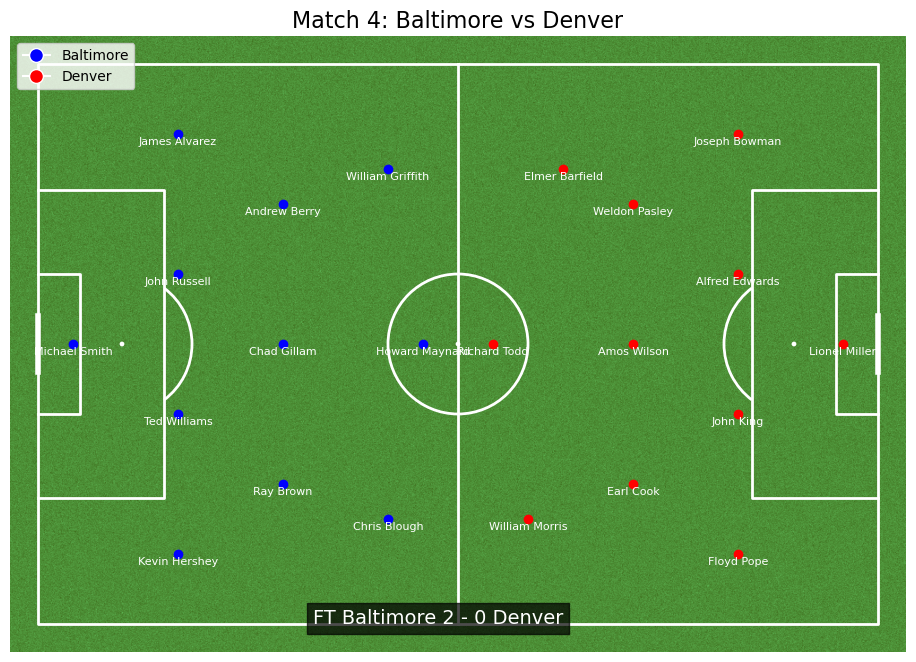

In [160]:
visualize_full_court_with_scorecard(4, starting_eleven, players, teams, results)

## Predicting the second season


### Feature Engineering

**Train data**

In [168]:
season1 = results[results['SeasonID'] == 1].copy()
season1 = pd.merge(season1, odds, on='MatchID', how='left')

In [ ]:
matches_with_positions = []

for _, row in season1.iterrows():
    match_id = row['MatchID']
    home_team_id = int(row['HomeTeamID'])
    away_team_id = int(row['AwayTeamID'])
    home_starting_xi = starting_eleven[starting_eleven['MatchID'] == match_id]['StartingXI'].iloc[0]
    away_starting_xi = starting_eleven[starting_eleven['MatchID'] == match_id]['StartingXI'].iloc[1]
    
    match_data = {
        'MatchID': match_id,
        'HomeTeamID': home_team_id,
        'AwayTeamID': away_team_id,
        'HomeGoalkeepers': get_players_by_position(home_starting_xi, players, 'Goalkeeper'),
        'HomeDefenders': get_players_by_position(home_starting_xi, players, 'Defender'),
        'HomeMidfielders': get_players_by_position(home_starting_xi, players, 'Midfielder'),
        'HomeForwards': get_players_by_position(home_starting_xi, players, 'Forward'),
        'AwayGoalkeepers': get_players_by_position(away_starting_xi, players, 'Goalkeeper'),
        'AwayDefenders': get_players_by_position(away_starting_xi, players, 'Defender'),
        'AwayMidfielders': get_players_by_position(away_starting_xi, players, 'Midfielder'),
        'AwayForwards': get_players_by_position(away_starting_xi, players, 'Forward'),
    }
    
    matches_with_positions.append(match_data)

matches_with_positions_df = pd.DataFrame(matches_with_positions)


In [ ]:
from collections import Counter

def get_most_common_starting_team(starting_eleven, players, teams):
    """
    Creates the most common starting team for each team in terms of the most starting goalkeeper,
    followed by 4 defenders, 3 midfielders, and 3 forwards.

    Parameters:
    - starting_eleven: DataFrame containing MatchID and StartingXI.
    - players: DataFrame containing player details including positions.
    - teams: DataFrame containing team details.

    Returns:
    - A DataFrame with the most common starting XI for each team.
    """
    most_common_starting_team = []
    for team_id in teams['TeamID']:
        team_starting_xi = starting_eleven[starting_eleven['MatchID'].isin(
            results[(results['HomeTeamID'] == team_id) | (results['AwayTeamID'] == team_id)]['MatchID']
        )]['StartingXI']

        all_players = [player.strip() for xi in team_starting_xi for player in xi.split(',')]
        player_counts = Counter(all_players)

        goalkeepers = [player for player in player_counts if players[(players['PlayerName'] == player) & (players['GoalKeeper'] == 'Goalkeeper')].any().any()]
        defenders = [player for player in player_counts if players[(players['PlayerName'] == player) & (players['GoalKeeper'] == 'Defender')].any().any()]
        midfielders = [player for player in player_counts if players[(players['PlayerName'] == player) & (players['GoalKeeper'] == 'Midfielder')].any().any()]
        forwards = [player for player in player_counts if players[(players['PlayerName'] == player) & (players['GoalKeeper'] == 'Forward')].any().any()]

        goalkeepers = sorted(goalkeepers, key=lambda x: player_counts[x], reverse=True)[:1]
        defenders = sorted(defenders, key=lambda x: player_counts[x], reverse=True)[:4]
        midfielders = sorted(midfielders, key=lambda x: player_counts[x], reverse=True)[:3]
        forwards = sorted(forwards, key=lambda x: player_counts[x], reverse=True)[:3]

        starting_xi = goalkeepers + defenders + midfielders + forwards
        most_common_starting_team.append({
            'TeamID': team_id,
            'MostCommon_StartingXI': ', '.join(starting_xi),
            'TeamName': teams[teams['TeamID'] == team_id]['TeamName'].iloc[0]
        })

    return pd.DataFrame(most_common_starting_team)

most_common_starting_team_df = get_most_common_starting_team(starting_eleven, players, teams)

# most_common_starting_team_df.head()

def divide_players_by_position(row, players):
    player_names = row['MostCommon_StartingXI'].split(', ')
    goalkeepers = [player for player in player_names if players[(players['PlayerName'] == player) & (players['GoalKeeper'] == 'Goalkeeper')].any().any()]
    defenders = [player for player in player_names if players[(players['PlayerName'] == player) & (players['GoalKeeper'] == 'Defender')].any().any()]
    midfielders = [player for player in player_names if players[(players['PlayerName'] == player) & (players['GoalKeeper'] == 'Midfielder')].any().any()]
    forwards = [player for player in player_names if players[(players['PlayerName'] == player) & (players['GoalKeeper'] == 'Forward')].any().any()]
    return pd.Series({
        'Goalkeepers': ', '.join(goalkeepers),
        'Defenders': ', '.join(defenders),
        'Midfielders': ', '.join(midfielders),
        'Forwards': ', '.join(forwards)
    })

position_columns = most_common_starting_team_df.apply(lambda row: divide_players_by_position(row, players), axis=1)
most_common_starting_team_df = pd.concat([most_common_starting_team_df, position_columns], axis=1)
most_common_starting_team_df.head()

,TeamID,MostCommon_StartingXI,TeamName,Goalkeepers,Defenders,Midfielders,Forwards
0,1,"Jeffrey Maxwell, Jason Kearns, Carl Sterling, ...",Arlington,Jeffrey Maxwell,"Jason Kearns, Carl Sterling, Robert Compton, J...","Robert Watson, Darin Pipkin, Vincent Woodby","Raymond Davis, David Hartman, Ralph Stine"
1,2,"Brent Wiley, Shawn Carr, Steven Taylor, Jim Th...",Anaheim,Brent Wiley,"Shawn Carr, Steven Taylor, Jim Thomas, Kirby R...","Charles Pesce, George Adams, Gregory Case","Robert Fain, Vincent Gore, Terry Dangelo"
2,3,"Maurice Troutman, Matthew Cook, Emil Hollins, ...",Atlanta,Maurice Troutman,"Matthew Cook, Emil Hollins, Robert Mendez, Tho...","Laverne Monaghan, Jonah Ruffin, Douglas Shepherd","Kenneth Morado, Kenneth Schaeffer, James Savage"
3,4,"Humberto Sherrard, Robert Graves, James Alvare...",Baltimore,Humberto Sherrard,"Robert Graves, James Alvarez, Kevin Hershey, C...","Earl White, Frank McCullough, Andrew Berry","Howard Maynard, Billy Colon, Howard Hurt"
4,5,"Steven Moore, Jose Vega, Ronnie Jacob, Fred Bu...",Boston,Steven Moore,"Jose Vega, Ronnie Jacob, Fred Burley, Walker W...","Michael McDaniel, Charles Gordon, Don Oliver","Robert Schaub, Earl Stone, Robin Sellers"


In [ ]:
matches_with_positions_df = matches_with_positions_df.merge(most_common_starting_team_df, left_on='HomeTeamID', right_on='TeamID', how='left') \
                                                     .rename(columns={
                                                         'Goalkeepers': 'Best_Home_Goalkeeper',
                                                         'Defenders': 'Best_Home_Defenders',
                                                         'Midfielders': 'Best_Home_Midfielders',
                                                         'Forwards': 'Best_Home_Forwards'
                                                     }).drop('TeamID', axis=1)

matches_with_positions_df = matches_with_positions_df.merge(most_common_starting_team_df, left_on='AwayTeamID', right_on='TeamID', how='left') \
                                                     .rename(columns={
                                                         'Goalkeepers': 'Best_Away_Goalkeeper',
                                                         'Defenders': 'Best_Away_Defenders',
                                                         'Midfielders': 'Best_Away_Midfielders',
                                                         'Forwards': 'Best_Away_Forwards'
                                                     }).drop('TeamID', axis=1)


# Add columns to indicate if the players match the best eleven
matches_with_positions_df['is_best_h_gk'] = matches_with_positions_df.apply(
    lambda row: 1 if row['HomeGoalkeepers'] == row['Best_Home_Goalkeeper'] else 0, axis=1)

matches_with_positions_df['is_best_h_def'] = matches_with_positions_df.apply(
    lambda row: 1 if set(row['HomeDefenders'].split(', ')) == set(row['Best_Home_Defenders'].split(', ')) else 0, axis=1)

matches_with_positions_df['is_best_h_mid'] = matches_with_positions_df.apply(
    lambda row: 1 if set(row['HomeMidfielders'].split(', ')) == set(row['Best_Home_Midfielders'].split(', ')) else 0, axis=1)

matches_with_positions_df['is_best_h_fwd'] = matches_with_positions_df.apply(
    lambda row: 1 if set(row['HomeForwards'].split(', ')) == set(row['Best_Home_Forwards'].split(', ')) else 0, axis=1)

matches_with_positions_df['is_best_a_gk'] = matches_with_positions_df.apply(
    lambda row: 1 if row['AwayGoalkeepers'] == row['Best_Away_Goalkeeper'] else 0, axis=1)

matches_with_positions_df['is_best_a_def'] = matches_with_positions_df.apply(
    lambda row: 1 if set(row['AwayDefenders'].split(', ')) == set(row['Best_Away_Defenders'].split(', ')) else 0, axis=1)

matches_with_positions_df['is_best_a_mid'] = matches_with_positions_df.apply(
    lambda row: 1 if set(row['AwayMidfielders'].split(', ')) == set(row['Best_Away_Midfielders'].split(', ')) else 0, axis=1)

matches_with_positions_df['is_best_a_fwd'] = matches_with_positions_df.apply(
    lambda row: 1 if set(row['AwayForwards'].split(', ')) == set(row['Best_Away_Forwards'].split(', ')) else 0, axis=1)

# Display the updated DataFrame
matches_with_positions_df.head()

,MatchID,HomeTeamID,AwayTeamID,HomeGoalkeepers,HomeDefenders,HomeMidfielders,HomeForwards,AwayGoalkeepers,AwayDefenders,AwayMidfielders,...,Best_Away_Midfielders,Best_Away_Forwards,is_best_h_gk,is_best_h_def,is_best_h_mid,is_best_h_fwd,is_best_a_gk,is_best_a_def,is_best_a_mid,is_best_a_fwd
0,1.0,7,1,Stephen Sallee,"Julius Skinner, Gerald Nelson, Porter Harris, ...","Michael Winters, Josh Fritz, Sammie Anderson","Edgar Gunter, Johnny Parker, Sidney Bell",Anthony Jennings,"Robert Compton, Scott Rosenberg, Antonio Carve...","Matthew Cabezas, Darin Pipkin, Herb Escobar",...,"Robert Watson, Darin Pipkin, Vincent Woodby","Raymond Davis, David Hartman, Ralph Stine",1,0,0,0,0,0,0,0
1,2.0,6,8,Daniel Enriquez,"Luis Lewis, Donald Talley, Edwin Brown","Gary Nichols, Michael Yang, Johnathon Bickham,...","Roberto Berry, Jeffrey Bachelder",Ronald Martinez,"Robert Locklear, Jerry Moeller, Henry Houle, S...","Harry Pope, Anthony Hartwell, Robert Jameson",...,"Harry Pope, Anthony Hartwell, Ronald Stein","Gregory Splawn, Ronald Caudillo, Daniel Lee",0,0,0,0,0,0,0,0
2,3.0,5,9,Craig Littleton,"Ralph Porter, Jose Vega, Fred Burley, Ricky Yates","Charles Gordon, Joseph Goff, Thomas Do, Matthe...","Robin Sellers, Michael McNeil",John Crouch,"Alfred Paradis, Craig Saleem, Steven Moeller","Charles Spillman, Matthew Harris, Michael Whee...",...,"Danny Sharp, Michael Wheeler, Reynaldo Hawkins","Isidro Swanson, Edward Diaz, Hugh Thomson",0,0,0,0,0,0,0,0
3,4.0,4,10,Michael Smith,"John Russell, James Alvarez, Kevin Hershey, Te...","Andrew Berry, Ray Brown, William Griffith, Cha...","Howard Maynard, Chris Blough",Lionel Miller,"Alfred Edwards, Joseph Bowman, John King, Floy...","William Morris, Amos Wilson, Weldon Pasley, Ea...",...,"Gregorio Davis, Henry Tevis, Weldon Pasley","Elmer Barfield, Anthony Lee, Erik Briggs",0,0,0,0,1,0,0,0
4,5.0,3,11,Rick Fernandez,"Randall Wilson, Robert Mendez, Thomas Bonner, ...","Jonah Ruffin, Douglas Shepherd, Thomas McGowan","Vincent Ray, Kenneth Schaeffer, James Savage",Joseph Toscano,"Joaquin Lewis, Nicholas Houston, Daryl Apodaca...","Brandon Hamilton, Walter Carter, Jimmy Jordan,...",...,"William Alexander, Jimmy Jordan, William Adams","George Rodriguez, Paul Dang, Michael Mason",0,0,0,0,1,0,0,0


In [ ]:
season1 = season1.merge(
    matches_with_positions_df[
        ['MatchID', 'is_best_h_gk', 'is_best_h_def', 'is_best_h_mid', 'is_best_h_fwd',
         'is_best_a_gk', 'is_best_a_def', 'is_best_a_mid', 'is_best_a_fwd']
    ],
    on='MatchID',
    how='left'
)

score  = season1[['HomeScore','HomeShots', 'AwayScore','AwayShots']]
x_train = season1.copy()
x_train = x_train.drop(columns=['MatchID', 'SeasonID', 'Gameweek','HomeScore', 'AwayScore', 'HomeShots', 'AwayShots'])
x_train_encoded = pd.get_dummies(x_train, columns=['HomeTeamID', 'AwayTeamID'], prefix=['HomeTeam', 'AwayTeam'])
x_train_encoded.iloc[:, 11:] = x_train_encoded.iloc[:, 11:].astype(int)


In [172]:
x_train_encoded.head()

,Home,Draw,Away,is_best_h_gk,is_best_h_def,is_best_h_mid,is_best_h_fwd,is_best_a_gk,is_best_a_def,is_best_a_mid,...,AwayTeam_19,AwayTeam_20,AwayTeam_21,AwayTeam_22,AwayTeam_23,AwayTeam_24,AwayTeam_25,AwayTeam_26,AwayTeam_27,AwayTeam_28
0,1.92,3.96,3.89,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2.16,3.88,3.23,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1.21,7.65,13.17,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1.05,17.00,43.49,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,3.12,3.60,2.32,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [173]:
y_train = score.apply(lambda row: 1 if row['HomeScore'] > row['AwayScore'] else (0 if row['HomeScore'] == row['AwayScore'] else -1), axis=1)
y_train.head()

0    0
1   -1
2    1
3    1
4    0
dtype: int64

**Test Data**

In [174]:
fixtures = pd.read_csv('fixtures.csv')
fixtures = fixtures.merge(odds, on='MatchID', how='left')


In [ ]:
fixtures_with_positions = []

for _, row in fixtures.iterrows():
    match_id = row['MatchID']
    home_team_id = int(row['HomeTeamID'])
    away_team_id = int(row['AwayTeamID'])
    home_starting_xi = starting_eleven[starting_eleven['MatchID'] == match_id]['StartingXI'].iloc[0]
    away_starting_xi = starting_eleven[starting_eleven['MatchID'] == match_id]['StartingXI'].iloc[1]
    
    match_data = {
        'MatchID': match_id,
        'HomeTeamID': home_team_id,
        'AwayTeamID': away_team_id,
        'HomeGoalkeepers': get_players_by_position(home_starting_xi, players, 'Goalkeeper'),
        'HomeDefenders': get_players_by_position(home_starting_xi, players, 'Defender'),
        'HomeMidfielders': get_players_by_position(home_starting_xi, players, 'Midfielder'),
        'HomeForwards': get_players_by_position(home_starting_xi, players, 'Forward'),
        'AwayGoalkeepers': get_players_by_position(away_starting_xi, players, 'Goalkeeper'),
        'AwayDefenders': get_players_by_position(away_starting_xi, players, 'Defender'),
        'AwayMidfielders': get_players_by_position(away_starting_xi, players, 'Midfielder'),
        'AwayForwards': get_players_by_position(away_starting_xi, players, 'Forward'),
    }
    
    fixtures_with_positions.append(match_data)

fixtures_with_positions_df = pd.DataFrame(fixtures_with_positions)
fixtures_with_positions_df = fixtures_with_positions_df.merge(most_common_starting_team_df, left_on='HomeTeamID', right_on='TeamID', how='left') \
                                                       .rename(columns={
                                                           'Goalkeepers': 'Best_Home_Goalkeeper',
                                                           'Defenders': 'Best_Home_Defenders',
                                                           'Midfielders': 'Best_Home_Midfielders',
                                                           'Forwards': 'Best_Home_Forwards'
                                                       }).drop('TeamID', axis=1)

fixtures_with_positions_df = fixtures_with_positions_df.merge(most_common_starting_team_df, left_on='AwayTeamID', right_on='TeamID', how='left') \
                                                       .rename(columns={
                                                           'Goalkeepers': 'Best_Away_Goalkeeper',
                                                           'Defenders': 'Best_Away_Defenders',
                                                           'Midfielders': 'Best_Away_Midfielders',
                                                           'Forwards': 'Best_Away_Forwards'
                                                       }).drop('TeamID', axis=1)



In [176]:
# Add columns to indicate if the players match the best eleven
fixtures_with_positions_df['is_best_h_gk'] = fixtures_with_positions_df.apply(
    lambda row: 1 if row['HomeGoalkeepers'] == row['Best_Home_Goalkeeper'] else 0, axis=1)

fixtures_with_positions_df['is_best_h_def'] = fixtures_with_positions_df.apply(
    lambda row: 1 if set(row['HomeDefenders'].split(', ')) == set(row['Best_Home_Defenders'].split(', ')) else 0, axis=1)

fixtures_with_positions_df['is_best_h_mid'] = fixtures_with_positions_df.apply(
    lambda row: 1 if set(row['HomeMidfielders'].split(', ')) == set(row['Best_Home_Midfielders'].split(', ')) else 0, axis=1)

fixtures_with_positions_df['is_best_h_fwd'] = fixtures_with_positions_df.apply(
    lambda row: 1 if set(row['HomeForwards'].split(', ')) == set(row['Best_Home_Forwards'].split(', ')) else 0, axis=1)

fixtures_with_positions_df['is_best_a_gk'] = fixtures_with_positions_df.apply(
    lambda row: 1 if row['AwayGoalkeepers'] == row['Best_Away_Goalkeeper'] else 0, axis=1)

fixtures_with_positions_df['is_best_a_def'] = fixtures_with_positions_df.apply(
    lambda row: 1 if set(row['AwayDefenders'].split(', ')) == set(row['Best_Away_Defenders'].split(', ')) else 0, axis=1)

fixtures_with_positions_df['is_best_a_mid'] = fixtures_with_positions_df.apply(
    lambda row: 1 if set(row['AwayMidfielders'].split(', ')) == set(row['Best_Away_Midfielders'].split(', ')) else 0, axis=1)

fixtures_with_positions_df['is_best_a_fwd'] = fixtures_with_positions_df.apply(
    lambda row: 1 if set(row['AwayForwards'].split(', ')) == set(row['Best_Away_Forwards'].split(', ')) else 0, axis=1)

# fixtures_with_positions_df

In [ ]:
x_test = fixtures[['MatchID','HomeTeamID','AwayTeamID','Home','Draw','Away']]
x_test = x_test.merge(
    fixtures_with_positions_df[
        ['MatchID','is_best_h_gk', 'is_best_h_def', 'is_best_h_mid', 'is_best_h_fwd',
         'is_best_a_gk', 'is_best_a_def', 'is_best_a_mid', 'is_best_a_fwd']
    ],
    on='MatchID',
    how='left'
)
x_test = x_test.drop(columns=['MatchID'])
x_test_encoded = pd.get_dummies(x_test, columns=['HomeTeamID', 'AwayTeamID'], prefix=['HomeTeam', 'AwayTeam'])
x_test_encoded.iloc[:, 11:] = x_test_encoded.iloc[:, 11:].astype(int)
# Display the updated x_test
x_test_encoded.head()

,Home,Draw,Away,is_best_h_gk,is_best_h_def,is_best_h_mid,is_best_h_fwd,is_best_a_gk,is_best_a_def,is_best_a_mid,...,AwayTeam_19,AwayTeam_20,AwayTeam_21,AwayTeam_22,AwayTeam_23,AwayTeam_24,AwayTeam_25,AwayTeam_26,AwayTeam_27,AwayTeam_28
0,6.32,5.02,1.49,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1.39,5.81,7.17,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2.12,3.84,3.35,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,27.20,10.17,1.12,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,12.38,7.60,1.22,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [178]:
season2 = results[results['SeasonID'] == 2].copy()
y_test = season2.apply(lambda row: 1 if row['HomeScore'] > row['AwayScore'] else (0 if row['HomeScore'] == row['AwayScore'] else -1), axis=1)
y_test.head()

756   -1
757    1
758   -1
759   -1
760   -1
dtype: int64

### Predictions using Logistic Regression

In [ ]:
log_reg = LogisticRegression(max_iter=1000, solver='lbfgs')
log_reg.fit(x_train_encoded, y_train)
y_pred_prob = log_reg.predict_proba(x_test_encoded)
y_pred_log = log_reg.predict(x_test_encoded)


In [184]:
# y_pred_prob

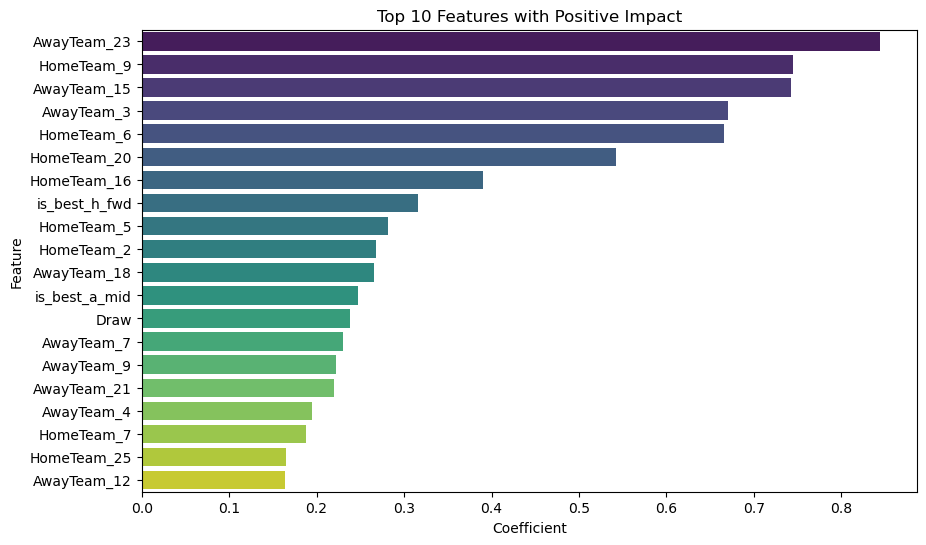

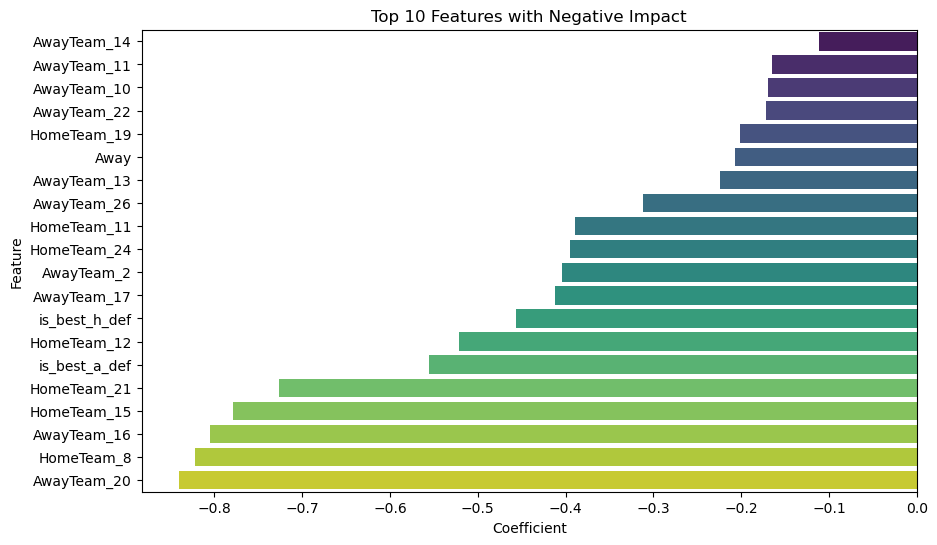

In [111]:
# Extract coefficients and feature names
coefficients = pd.DataFrame({
    'Feature': x_train_encoded.columns,
    'Coefficient': log_reg.coef_[0]
}).sort_values(by='Coefficient', ascending=False)

# Visualize the coefficients
plt.figure(figsize=(10, 6))
sns.barplot(x='Coefficient', y='Feature', hue='Feature', data=coefficients.head(20), palette='viridis', legend=False)
plt.title('Top 10 Features with Positive Impact')
plt.show()

plt.figure(figsize=(10, 6))
sns.barplot(x='Coefficient', y='Feature', hue='Feature', data=coefficients.tail(20), palette='viridis', legend=False)
plt.title('Top 10 Features with Negative Impact')
plt.show()


Accuracy: 0.59
Precision: 0.54
Recall: 0.59
F1 Score: 0.56


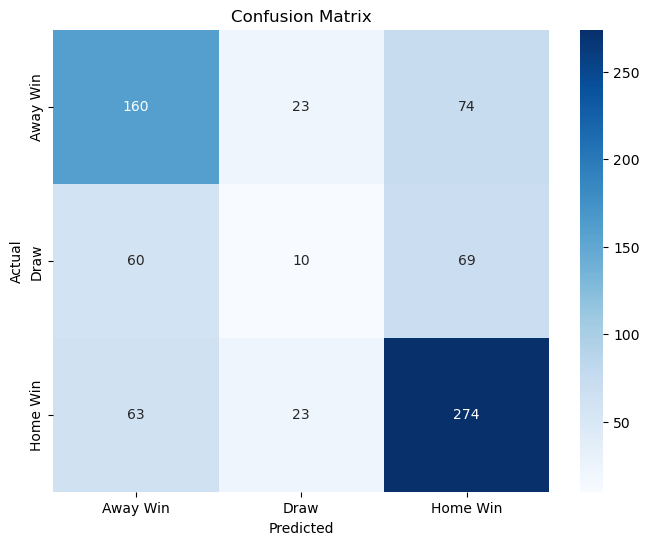

In [ ]:
precision_log = precision_score(y_test, y_pred_log, average='weighted')
recall_log = recall_score(y_test, y_pred_log, average='weighted')
f1_log= f1_score(y_test, y_pred_log, average='weighted')
accuracy_log = accuracy_score(y_test, y_pred_log)

# Calculate confusion matrix
conf_matrix_log = confusion_matrix(y_test, y_pred_log)

# Print the results
print(f"Accuracy: {accuracy_log:.2f}")
print(f"Precision: {precision_log:.2f}")
print(f"Recall: {recall_log:.2f}")
print(f"F1 Score: {f1_log:.2f}")

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_log, annot=True, fmt='d', cmap='Blues', xticklabels=['Away Win', 'Draw', 'Home Win'], yticklabels=['Away Win', 'Draw', 'Home Win'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

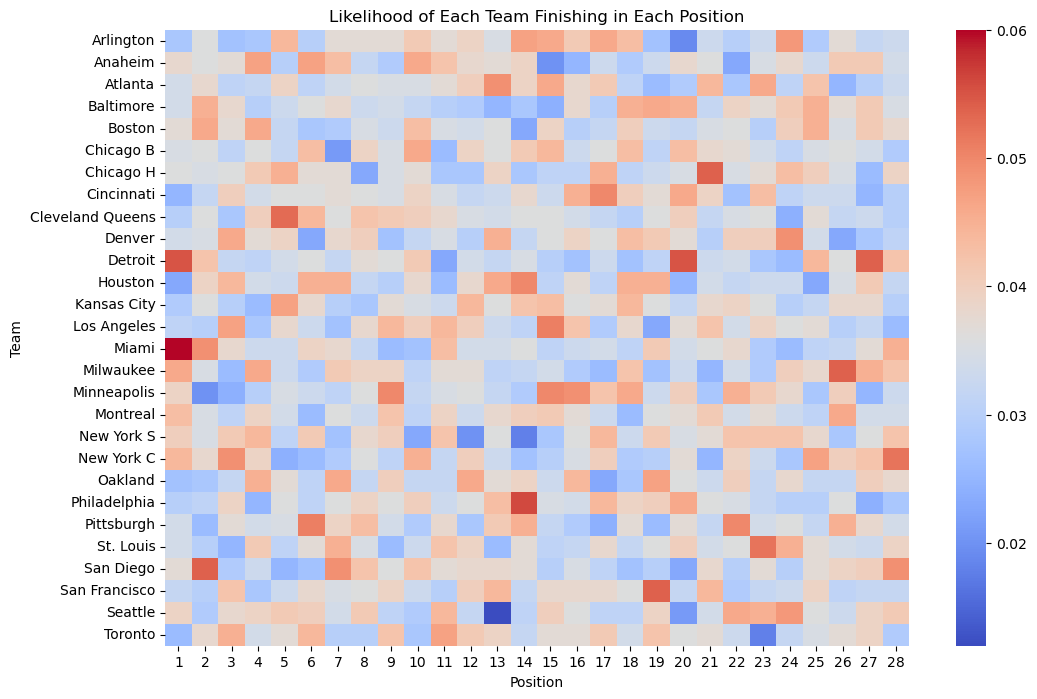

In [ ]:
num_teams = len(teams)
num_positions = num_teams
position_probabilities = np.zeros((num_teams, num_positions))

num_simulations = 1000
for _ in range(num_simulations):
    simulated_results = np.random.choice(y_pred_log, size=len(y_pred_log), replace=True)
    
    simulated_standings = standings.copy()
    simulated_standings['SimulatedPoints'] = simulated_standings['TeamID'].map(
        lambda team_id: (simulated_results[(x_test['HomeTeamID'] == team_id) & (simulated_results == 1)].sum() * 3) +
                        (simulated_results[(x_test['HomeTeamID'] == team_id) & (simulated_results == 0)].sum() * 1) +
                        (simulated_results[(x_test['AwayTeamID'] == team_id) & (simulated_results == -1)].sum() * 3) +
                        (simulated_results[(x_test['AwayTeamID'] == team_id) & (simulated_results == 0)].sum() * 1)
    )
    
    simulated_standings = simulated_standings.sort_values(by='SimulatedPoints', ascending=False).reset_index(drop=True)
    simulated_standings['SimulatedPosition'] = simulated_standings.index + 1
    
    for team_id, position in zip(simulated_standings['TeamID'], simulated_standings['SimulatedPosition']):
        position_probabilities[team_id - 1, position - 1] += 1
position_probabilities /= num_simulations
plt.figure(figsize=(12, 8))
sns.heatmap(position_probabilities, annot=False, cmap='coolwarm', xticklabels=range(1, num_positions + 1), yticklabels=teams['TeamName'])
plt.title('Likelihood of Each Team Finishing in Each Position')
plt.xlabel('Position')
plt.ylabel('Team')
plt.show()

### Prediction using Random Forest

In [ ]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(x_train_encoded, y_train)
y_pred_rf = rf_model.predict(x_test_encoded)

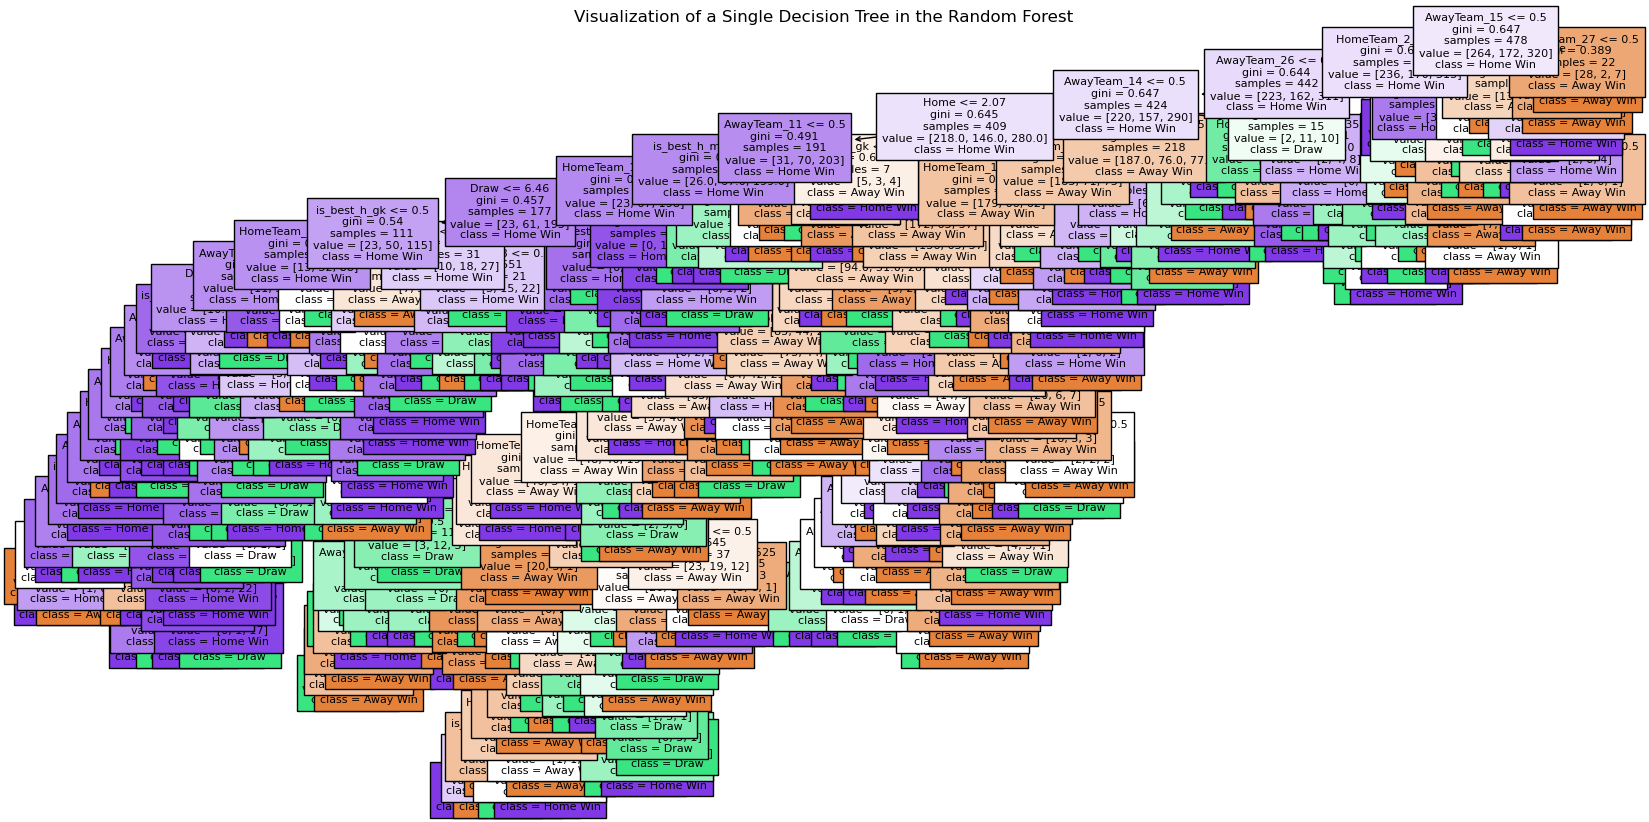

In [ ]:
tree = rf_model.estimators_[0]

# Visualize the tree using plot_tree
plt.figure(figsize=(20, 10))
plot_tree(tree, feature_names=x_train_encoded.columns, class_names=['Away Win', 'Draw', 'Home Win'], filled=True, fontsize=8)
plt.title("Visualization of a Single Decision Tree in the Random Forest")
plt.show()

Accuracy: 0.57
Precision: 0.53
Recall: 0.57
F1 Score: 0.54


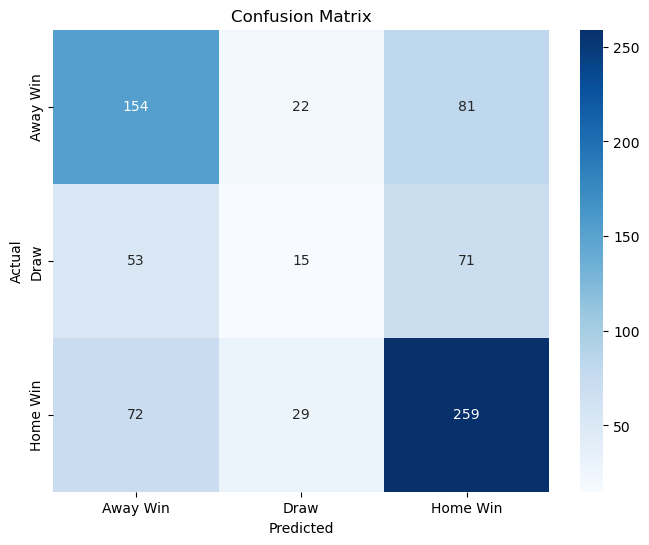

In [ ]:
precision_rf = precision_score(y_test, y_pred_rf, average='weighted')
recall_rf = recall_score(y_test, y_pred_rf, average='weighted')
f1_rf = f1_score(y_test, y_pred_rf, average='weighted')
accuracy_rf = accuracy_score(y_test, y_pred_rf)

# Calculate confusion matrix
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)

# Print the results
print(f"Accuracy: {accuracy_rf:.2f}")
print(f"Precision: {precision_rf:.2f}")
print(f"Recall: {recall_rf:.2f}")
print(f"F1 Score: {f1_rf:.2f}")

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_rf, annot=True, fmt='d', cmap='Blues', xticklabels=['Away Win', 'Draw', 'Home Win'], yticklabels=['Away Win', 'Draw', 'Home Win'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

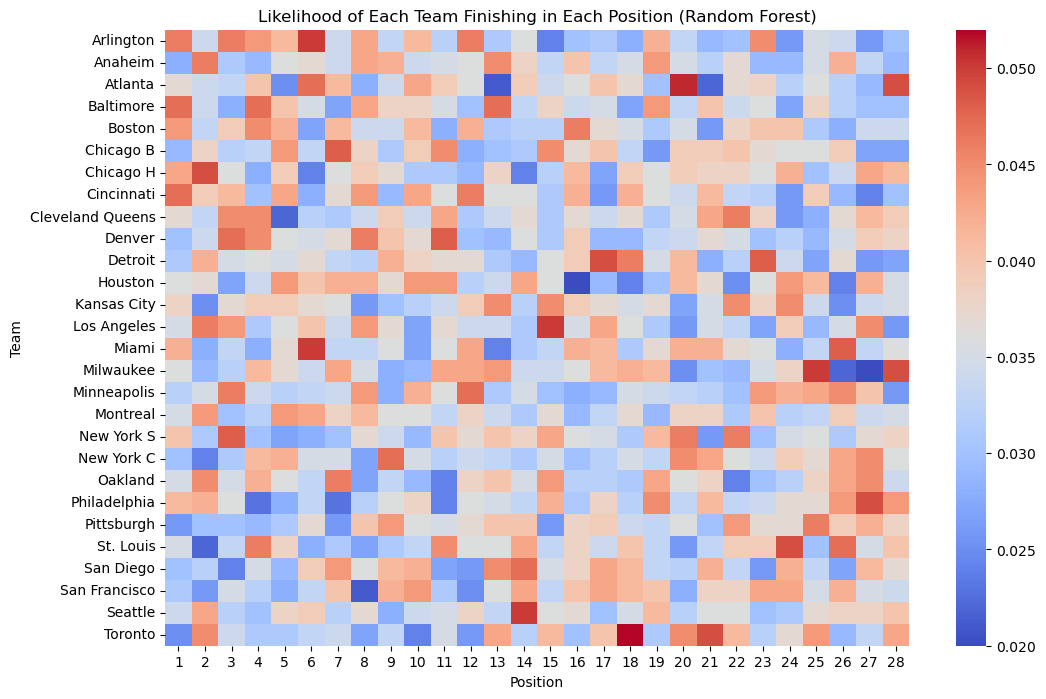

In [ ]:
num_teams = len(teams)
num_positions = num_teams
position_probabilities_rf = np.zeros((num_teams, num_positions))

num_simulations = 1000
for _ in range(num_simulations):
    simulated_results = np.random.choice(y_pred_rf, size=len(y_pred_rf), replace=True)
    simulated_points = {team_id: 0 for team_id in teams['TeamID']}
    for i, result in enumerate(simulated_results):
        home_team = x_test.iloc[i]['HomeTeamID']
        away_team = x_test.iloc[i]['AwayTeamID']
        if result == 1:  # Home win
            simulated_points[home_team] += 3
        elif result == 0:  # Draw
            simulated_points[home_team] += 1
            simulated_points[away_team] += 1
        elif result == -1:  # Away win
            simulated_points[away_team] += 3
    
    sorted_teams = sorted(simulated_points.items(), key=lambda x: x[1], reverse=True)
    for position, (team_id, _) in enumerate(sorted_teams):
        position_probabilities_rf[team_id - 1, position] += 1

position_probabilities_rf /= num_simulations
plt.figure(figsize=(12, 8))
sns.heatmap(position_probabilities_rf, annot=False, cmap='coolwarm', xticklabels=range(1, num_positions + 1), yticklabels=teams['TeamName'])
plt.title('Likelihood of Each Team Finishing in Each Position (Random Forest)')
plt.xlabel('Position')
plt.ylabel('Team')
plt.show()

### Prediction using Multi Layer Perceptron (Neural Networks)

In [145]:
# pip install tensorflow

In [ ]:
model = Sequential([
    Dense(100, activation='relu', input_dim=x_train_encoded.shape[1]),
    Dropout(0.3),
    Dense(50, activation='relu'),
    Dropout(0.3),
    Dense(25, activation='relu'),
    Dropout(0.3),
    Dense(3, activation='softmax') 
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
y_train_mlp = y_train.map({-1: 0, 0: 1, 1: 2})
y_test_mlp = y_test.map({-1: 0, 0: 1, 1: 2})

history = model.fit(x_train_encoded, y_train_mlp, epochs=50, batch_size=32, validation_split=0.2, verbose=1)
y_pred_probs = model.predict(x_test_encoded)
y_pred_mlp = y_pred_probs.argmax(axis=1) - 1  # Convert back to -1, 0, 1

Epoch 1/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4852 - loss: 1.0976 - val_accuracy: 0.6184 - val_loss: 0.8376
Epoch 2/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4776 - loss: 1.0198 - val_accuracy: 0.6776 - val_loss: 0.8572
Epoch 3/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5891 - loss: 0.9147 - val_accuracy: 0.6974 - val_loss: 0.8296
Epoch 4/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5898 - loss: 0.9383 - val_accuracy: 0.6842 - val_loss: 0.8446
Epoch 5/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5733 - loss: 0.9565 - val_accuracy: 0.6513 - val_loss: 0.8450
Epoch 6/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5554 - loss: 1.0116 - val_accuracy: 0.6776 - val_loss: 0.8374
Epoch 7/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5487 - loss: 0.8921 - val_accuracy: 0.6908 - val_loss: 0.8365
Epoch 8/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5684 - loss: 0.9252 - val_accuracy: 0.6776 - val_loss:

Accuracy: 0.59
Precision: 0.54
Recall: 0.59
F1 Score: 0.55


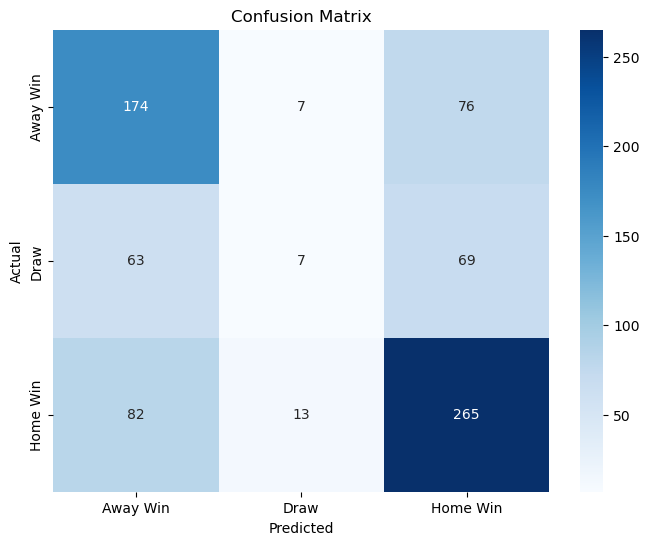

In [ ]:
accuracy_mlp = accuracy_score(y_test, y_pred_mlp)
precision_mlp = precision_score(y_test, y_pred_mlp, average='weighted')
recall_mlp = recall_score(y_test, y_pred_mlp, average='weighted')
f1_mlp = f1_score(y_test, y_pred_mlp, average='weighted')
conf_matrix_mlp = confusion_matrix(y_test, y_pred_mlp)

# Print the results
print(f"Accuracy: {accuracy_mlp:.2f}")
print(f"Precision: {precision_mlp:.2f}")
print(f"Recall: {recall_mlp:.2f}")
print(f"F1 Score: {f1_mlp:.2f}")

# Confusion matrix
conf_matrix_mlp = confusion_matrix(y_test, y_pred_mlp)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_mlp, annot=True, fmt='d', cmap='Blues', xticklabels=['Away Win', 'Draw', 'Home Win'], yticklabels=['Away Win', 'Draw', 'Home Win'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

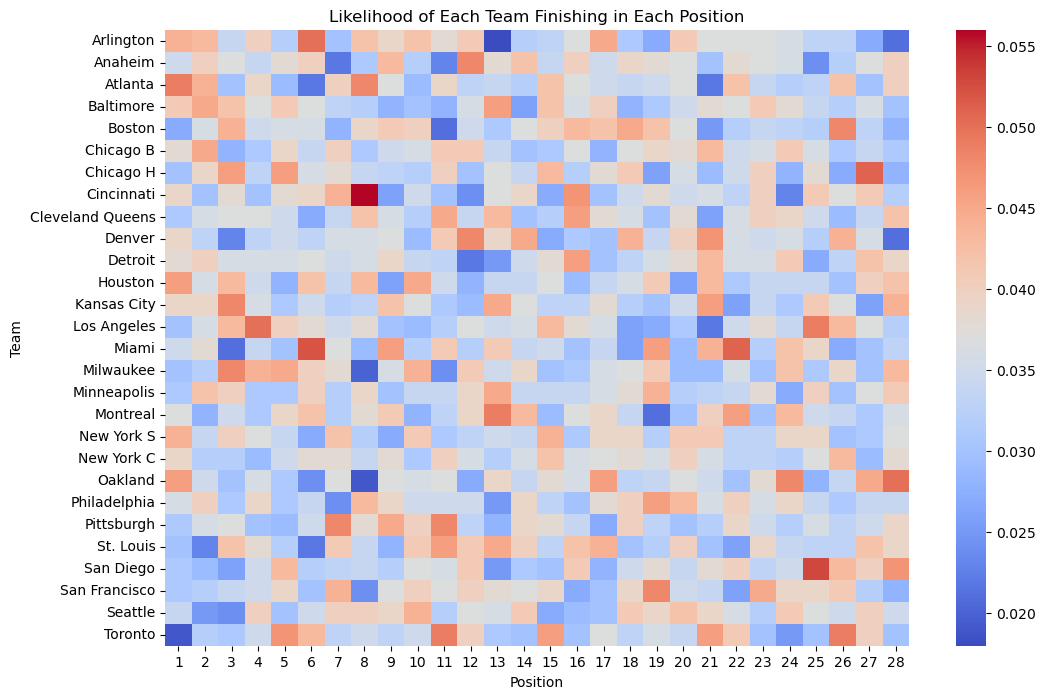

In [ ]:
# Create a DataFrame to store the probabilities
num_teams = len(teams)
num_positions = num_teams
position_probabilities = np.zeros((num_teams, num_positions))

# Simulate multiple seasons using the model predictions
num_simulations = 1000
for _ in range(num_simulations):
    # Shuffle the predictions to simulate randomness
    simulated_results = np.random.choice(y_pred_log, size=len(y_pred_log), replace=True)
    
    # Calculate points for each team
    simulated_points = {team_id: 0 for team_id in teams['TeamID']}
    for i, result in enumerate(simulated_results):
        home_team = x_train.iloc[i]['HomeTeamID']
        away_team = x_train.iloc[i]['AwayTeamID']
        if result == 1:  # Home win
            simulated_points[home_team] += 3
        elif result == 0:  # Draw
            simulated_points[home_team] += 1
            simulated_points[away_team] += 1
        elif result == -1:  # Away win
            simulated_points[away_team] += 3
    
    # Sort teams by simulated points
    sorted_teams = sorted(simulated_points.items(), key=lambda x: x[1], reverse=True)
    for position, (team_id, _) in enumerate(sorted_teams):
        position_probabilities[team_id - 1, position] += 1

# Normalize probabilities
position_probabilities /= num_simulations

# Create a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(position_probabilities, annot=False, cmap='coolwarm', xticklabels=range(1, num_positions + 1), yticklabels=teams['TeamName'])
plt.title('Likelihood of Each Team Finishing in Each Position')
plt.xlabel('Position')
plt.ylabel('Team')
plt.show()

#### Comparison between the three models

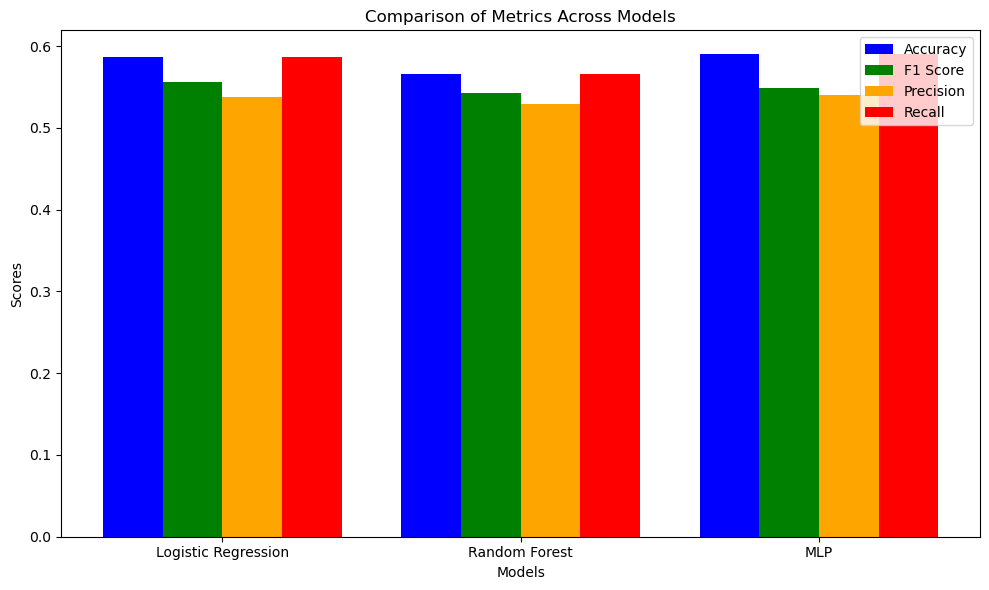

In [ ]:
models = ['Logistic Regression', 'Random Forest', 'MLP']
accuracy = [accuracy_log, accuracy_rf, accuracy_mlp]
f1_scores = [f1_log, f1_rf, f1_mlp]
precision = [precision_log, precision_rf, precision_mlp]
recall = [recall_log, recall_rf, recall_mlp]

# Create a bar width
bar_width = 0.2
x = np.arange(len(models))

# Plot the metrics
plt.figure(figsize=(10, 6))
plt.bar(x - bar_width * 1.5, accuracy, width=bar_width, label='Accuracy', color='blue')
plt.bar(x - bar_width * 0.5, f1_scores, width=bar_width, label='F1 Score', color='green')
plt.bar(x + bar_width * 0.5, precision, width=bar_width, label='Precision', color='orange')
plt.bar(x + bar_width * 1.5, recall, width=bar_width, label='Recall', color='red')

# Add labels, title, and legend
plt.xlabel('Models')
plt.ylabel('Scores')
plt.title('Comparison of Metrics Across Models')
plt.xticks(x, models)
plt.legend()
plt.tight_layout()

# Show the plot
plt.show()

### Results

The plot compares the performance of three models Logistic Regression, Random Forest, and Multi-Layer Perceptron (MLP) across four metrics: Accuracy, F1 Score, Precision, and Recall. 

- **Accuracy**: All models perform similarly, with Logistic Regression slightly outperforming the others.
- **F1 Score**: Logistic Regression is slighly better than other two models with 0.56.
- **Precision**: MLP demonstrates the highest precision, followed closely by Random Forest and Logistic Regression.
- **Recall**: MLP perform slightly better, with MLP showing slightly lower recall.

Overall, Logistic Regression appears to be the most balanced model, excelling in f1score and accuracy, 

#### Explanation of Metrics

1. **Accuracy**:
    - **Definition**: The ratio of correctly predicted outcomes to the total number of predictions.
    - **Formula**: Accuracy = (Correct Predictions) / (Total Predictions)
    - **Interpretation**: Measures the overall correctness of the model. High accuracy indicates that the model performs well across all classes.

2. **Precision**:
    - **Definition**: The ratio of true positive predictions to the total positive predictions made by the model.
    - **Formula**: Precision = True Positives / (True Positives + False Positives)
    - **Interpretation**: Indicates how many of the predicted positive outcomes are actually correct. High precision means fewer false positives.

3. **Recall**:
    - **Definition**: The ratio of true positive predictions to the total actual positives in the dataset.
    - **Formula**: Recall = True Positives / (True Positives + False Negatives)
    - **Interpretation**: Measures the ability of the model to identify all relevant instances. High recall means fewer false negatives.

4. **F1 Score**:
    - **Definition**: The harmonic mean of precision and recall.
    - **Formula**: F1 = 2 * (precision * recall) / (precision + recall)
    - **Interpretation**: Balances precision and recall, especially useful when the dataset is imbalanced. High F1 score indicates a good balance between precision and recall.

5. **Confusion Matrix**:
    - **Definition**: A table that summarizes the performance of a classification model by showing the counts of true positives, true negatives, false positives, and false negatives.
    - **Structure**:
      - Rows represent the actual classes.
      - Columns represent the predicted classes.
    - **Interpretation**: Helps to understand the types of errors the model is making and which classes are being confused.

These metrics collectively provide a comprehensive evaluation of the model's performance, highlighting its strengths and weaknesses in different aspects.